# Get the Data

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [137]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


## Define global constants

In [138]:
MY_OPTIMIZER = "SGD"
MY_EPOCHS = 100
#MY_LEARNING_RATE = 0.1

# Get the Data

In [139]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()
maneuvers.shape

(3224, 8)

In [140]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,3224.000000,3224.000000,3.224000e+03,3224.000000,3.224000e+03,3224.000000,3.224000e+03,3.224000e+03
mean,1886.576428,-0.990425,-6.088192e-07,-0.000166,-3.862162e-07,-0.000003,2.820395e-07,5.069344e-14
std,1087.697443,0.001020,3.211659e-03,0.000709,2.138426e-03,0.006602,1.462522e-03,7.296394e-14
min,3.505562,-0.991665,-4.521060e-03,-0.001121,-3.245553e-03,-0.009033,-2.051272e-03,-7.445924e-14
25%,945.040995,-0.991457,-3.228282e-03,-0.000869,-1.978059e-03,-0.006519,-1.473655e-03,-6.682239e-15
50%,1886.576428,-0.990586,1.192437e-06,-0.000218,-4.672567e-07,-0.000392,-8.308235e-07,3.199093e-14
75%,2828.111861,-0.989401,3.222703e-03,0.000535,1.981781e-03,0.006449,1.472022e-03,1.077307e-13
max,3769.647294,-0.988843,4.521061e-03,0.000898,3.245554e-03,0.009931,2.051271e-03,2.230983e-13


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [141]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)


# Prepare the Data for Machine Learning Algorithms

In [142]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()


# Convert dataframe to a numpy array before training, to avoid issues with dataframe headers.
maneuvers_predictors = maneuvers_predictors.to_numpy()
maneuvers_labels = maneuvers_labels.to_numpy()

#maneuvers_predictors.head()
#maneuvers_labels.head()

## Create a Train/Test/Validation Set

In [143]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
#X_train.head()

(1934, 6)
(645, 6)
(645, 6)


In [144]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[9.75036948e-01, 6.29303792e-01, 1.51252100e-02, 6.64168831e-01,
        1.63415636e-02, 3.86754374e-01],
       [3.35245578e-01, 9.99472128e-01, 4.91420900e-01, 9.52066595e-01,
        4.98477246e-01, 3.79552495e-03],
       [9.99847479e-01, 5.10176664e-01, 9.19227309e-05, 5.13022843e-01,
        9.95514165e-05, 4.91114305e-01],
       [7.28067504e-01, 1.05073329e-01, 1.75076854e-01, 4.23280451e-02,
        1.84524224e-01, 8.58500526e-01],
       [1.46756280e-02, 7.02651725e-01, 9.51334213e-01, 5.73590710e-01,
        9.48896410e-01, 2.56279421e-01]])

In [145]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)
y_valid_scaled = scaler_target.transform(y_valid)
y_test_scaled = scaler_target.transform(y_test)

In [146]:
import joblib
joblib.dump(scaler, 'scaler.gz')
joblib.dump(scaler_target, 'scaler_target.gz')

['scaler_target.gz']

# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [147]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train_scaled.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 300)            │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,301 (126.18 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
model.compile(loss="mean_squared_error", optimizer=MY_OPTIMIZER)
history = model.fit(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, 
                    validation_data=(X_valid_scaled, y_valid_scaled))

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1619 - val_loss: 0.0349
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0312 - val_loss: 0.0234
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0230 - val_loss: 0.0187
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0189 - val_loss: 0.0162
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157 - val_loss: 0.0146
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0133
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0124
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0122 - val_loss: 0.0109
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 70/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 71/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 72/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 73/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 74/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 75/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 76/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 77/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 78/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 79/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 80/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 

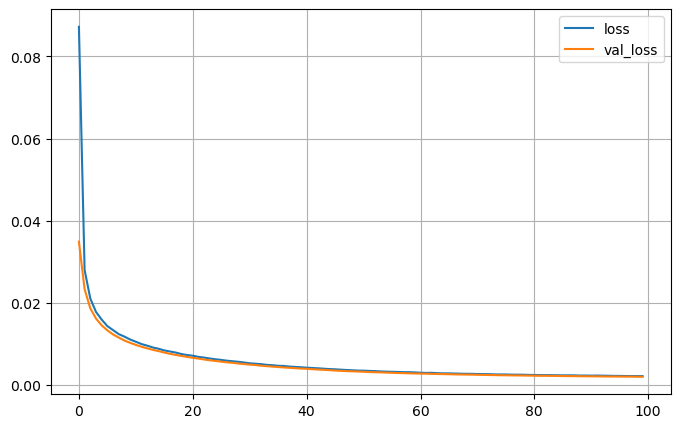

In [149]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [150]:
mse_test = model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.0018


0.04672690431613012

In [151]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [152]:
y_test_scaled[:3]

array([[0.16081392],
       [0.29471611],
       [0.40072202]])

In [153]:
y_pred[:3]

array([[0.16042954],
       [0.2661861 ],
       [0.41679144]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [154]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model


In [155]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid_scaled . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train_scaled, epochs=100,
                  validation_data=(X_valid, y_valid_scaled),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [156]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [157]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [158]:
tuner.search(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, validation_data=(X_valid_scaled, y_valid_scaled))

Trial 20 Complete [00h 00m 21s]
val_loss: 0.001982813060749322

Best val_loss So Far: 0.0014049331075511873
Total elapsed time: 00h 08m 11s


## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [159]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 288)            │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 384)            │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 288)            │       110,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,481 (955.00 KB)

 Trainable params: 244,481 (955.00 KB)

 Non-trainable params: 0 (0.00 B)

In [160]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
num_layers: 5
units_0: 288
units_1: 384
units_2: 288
units_3: 64
units_4: 32
Score: 0.0014049331075511873

Trial 17 summary
Hyperparameters:
num_layers: 5
units_0: 416
units_1: 256
units_2: 32
units_3: 64
units_4: 384
Score: 0.001455070509109646

Trial 18 summary
Hyperparameters:
num_layers: 5
units_0: 96
units_1: 480
units_2: 384
units_3: 96
units_4: 192
Score: 0.0014595367829315364

Trial 12 summary
Hyperparameters:
num_layers: 5
units_0: 192
units_1: 480
units_2: 256
units_3: 32
units_4: 192
Score: 0.001485395128838718

Trial 06 summary
Hyperparameters:
num_layers: 4
units_0: 352
units_1: 192
units_2: 320
units_3: 32
Score: 0.0015281838132068515

Trial 10 summary
Hyperparameters:
num_layers: 5
units_0: 96
units_1: 192
units_2: 320
units_3: 160
units_4: 512
Score: 0.0015374946524389088

Trial 15 summary
Hyperparameters:
num_layers: 4
units

In [161]:
mse_test = best_model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012     


0.03757877309145159

In [162]:
X_new = X_test_scaled[:10] # pretend these are new instances
y_pred = best_model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [163]:
y_test_scaled[:10]

array([[0.16081392],
       [0.29471611],
       [0.40072202],
       [0.1851001 ],
       [0.12668198],
       [0.06432557],
       [0.14702987],
       [0.08697079],
       [0.90351165],
       [0.30817197]])

In [164]:
y_pred[:10]

array([[0.1583145 ],
       [0.2636171 ],
       [0.41388053],
       [0.15737362],
       [0.10261032],
       [0.08812673],
       [0.14871599],
       [0.12455128],
       [0.9073841 ],
       [0.30409145]], dtype=float32)

In [165]:
best_model.save("best_model.keras")